In [1]:
import numpy as np
import pandas as pd
import datetime
import pytz
from matplotlib import pyplot as plt
import matplotlib as mpl
import logging
import hvplot.pandas
logging.basicConfig(level=logging.INFO)

In [2]:
datestr = datetime.datetime.strftime(datetime.datetime.now(),'%Y%m%d')

In [3]:
def rho_w(T):#density of water kg/m3 at T deg C
    #10.1088/0026-1394/38/4/3
    a = [-3.983035,301.797,522528.9,69.34881,999.97495]
    return a[4]*(1-(T+a[0])**2*(T+a[1])/a[2]/(T+a[3]))
def latent(T):#latent heat of vaporization kJ/kg at T deg C
    return 2501 - 0002.361 * T
def vpd(rh,t):
    #tetens
    es = esa(t)
    return es *(1- rh / 100)

def esa(T):#saturation vapor pressure kPa, T is temp in deg C
    return  0.61078 * np.exp((17.269 * T) / (237.3 + T))

In [ ]:
cook_flux = pd.read_csv('/90daydata/nsaru/work/CookIRCamET/Meteorological/Cook/EcTower/REddyProc/CookEast/6503_20240805_REP_output.csv',skiprows=[1,2],sep='\t').replace(to_replace=-9999,value=np.nan)

In [ ]:
cook_hy2023_v1 = pd.read_csv('/90daydata/nsaru/work/CookIRCamET/Working/cookhy2023_V1_pa_output.csv')
cook_hy2023_v2 = pd.read_csv('/90daydata/nsaru/work/CookIRCamET/Working/cookhy2023_V2_pa_output.csv')
cook_hy2024_v3 = pd.read_csv('/90daydata/nsaru/work/CookIRCamET/Working/cookhy2024_V3_pa_output.csv')

In [ ]:
cook_hy2024_v3

In [ ]:
cook_hy2023_v1['times'] = pd.to_datetime(cook_hy2023_v1.times)
cook_hy2023_v2['times'] = pd.to_datetime(cook_hy2023_v2.times)
cook_hy2024_v3['times'] = pd.to_datetime(cook_hy2024_v3.times)

In [ ]:
cook_hys = pd.concat([cook_hy2023_v1,cook_hy2023_v2,cook_hy2024_v3]).reset_index()

In [ ]:
cook_flux = cook_flux[['Year', 'DoY', 'Hour', 'Rg', 'Tair', 'rH', 'VPD', 'LE_uStar_f']]
cook_flux['lambda']=cook_flux.Tair.apply(latent)
cook_flux['rho_w']=cook_flux.Tair.apply(rho_w)

In [ ]:
cook_flux['ET']=cook_flux['LE_uStar_f']/cook_flux['lambda']/cook_flux['rho_w']*60*30#mm H20 in 30min
cook_flux['Minutes']=60*(cook_flux['Hour']-np.floor(cook_flux['Hour']))

In [ ]:
cook_flux['Hour']=np.floor(cook_flux['Hour'])

In [ ]:
cook_flux = cook_flux[['Year', 'DoY', 'Hour', 'Minutes', 'Rg', 'Tair', 'rH', 'VPD','ET']]

In [ ]:
cook_flux['times']=pd.to_datetime(cook_flux['Year'].astype(str) + ' ' + cook_flux['DoY'].astype(str) + ' ' + cook_flux['Hour'].astype(int).astype(str)+':'+cook_flux['Minutes'].astype(int).astype(str),
    format='%Y %j %H:%M'
   )

In [ ]:
#half-hourly to hourly
cook_flux=cook_flux.groupby(['Year','DoY','Hour']).agg({'times':'max', 'Rg':'mean', 'Tair':'mean', 'rH':'mean', 'VPD':'mean', 'ET':'sum'}).reset_index()

In [ ]:
cook_flux['times'] = cook_flux.times.dt.tz_localize('Etc/GMT+8')

In [ ]:
cook_flux['times'] = cook_flux.times.dt.tz_convert('UTC')

In [ ]:
#should check tz's match

In [ ]:
cook_flux.Tair+=273.15

In [ ]:
ax = cook_hys.plot(x='times',y='Trsun',
                 xlim = [cook_hys.times.values[-96],cook_hys.times.values[-1]],ylim=[270,320])

cook_flux.plot(x='times',y='Tair',
                 xlim = [cook_hys.times.values[-96],cook_hys.times.values[-1]],ylim=[270,320],ax=ax)

In [ ]:
xlim=[pd.to_datetime('2023-01-01 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2024-07-10 00:00:00',format='%Y-%m-%d %H:%M:%S')]

In [ ]:
cook_hys.plot(x='times',y=['Trsun'],xlim=xlim,ylim=[240,340])

In [ ]:
cook_flux.plot(x='times',y=['ET'],xlim=xlim)

In [ ]:
cook_hys['times2']=cook_hys['times']
for i in cook_hys.index:
    mask = abs(cook_hys.loc[i,'times']-cook_flux['times'])==min(abs(cook_hys.loc[i,'times']-cook_flux['times']))
    cook_hys.loc[i,'times2'] = cook_flux.loc[mask,'times'].values[0]

In [ ]:
cook_hys = cook_hys.drop(columns=['times'])

In [ ]:
cook_hys = cook_hys.rename(columns={'times2':'times'}).drop(columns=['index', 'Unnamed: 0'])

In [ ]:
cook_hys['times'] = cook_hys.astype({'times':'datetime64[ns]'}).reset_index().times.dt.tz_localize('UTC')

In [ ]:
cook_flux = cook_flux.merge(cook_hys,how='left')
cook_flux=cook_flux[cook_flux.times>=cook_hys.times.min()]
cook_flux=cook_flux[cook_flux.times<=cook_hys.times.max()]

In [ ]:
inputs = ['elevation', 'azimuth', 'fssun',
       'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd', 'fwsun', 'fwshd', 'Tssun',
       'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd', 'Twsun', 'Twshd']
outputs = ['ET']

In [ ]:
for i in inputs:
    if 'T' in i:
        cook_flux.loc[cook_flux[i]<250,i]=np.nan

In [ ]:
bad_ir = cook_flux.apply(lambda p: np.all(np.isnan(p[['Tsshd', 'Trshd', 'Tvshd', 'Twshd']].astype('float64').values)),axis=1)

In [ ]:
cook_flux['BadIR']=bad_ir

In [ ]:
cook_flux['Hour']=cook_flux.times.dt.hour

In [ ]:
cook_flux = cook_flux.groupby('times').aggregate('mean').reset_index()

In [ ]:
cook_flux.to_csv('/90daydata/nsaru/work/CookIRCamET/Working/cook_hys_ec_'+datestr+'.csv',index=False)

In [ ]:
cook_flux = pd.read_csv('/90daydata/nsaru/work/CookIRCamET/Working/cook_hys_ec_'+datestr+'.csv')

In [ ]:
cook_flux_interp = cook_flux.copy().drop_duplicates().sort_values('times')

In [ ]:
cook_flux_interp

In [ ]:
end_idx_0 = cook_flux_interp[cook_flux_interp.times=='2022-11-16 21:30:00+00:00'].index[0]
start_idx_0 = cook_flux_interp[cook_flux_interp.times=='2022-11-27 16:30:00+00:00'].index[0]

end_idx_1 = cook_flux_interp[cook_flux_interp.times=='2023-02-21 01:30:00+00:00'].index[0]
start_idx_1 = cook_flux_interp[cook_flux_interp.times=='2023-03-20 17:30:00+00:00'].index[0]

end_idx_2 = cook_flux_interp[cook_flux_interp.times=='2023-03-22 03:30:00+00:00'].index[0]
start_idx_2 = cook_flux_interp[cook_flux_interp.times=='2023-05-22 17:30:00+00:00'].index[0]

end_idx_3 = cook_flux_interp[cook_flux_interp.times=='2023-07-18 16:30:00+00:00'].index[0]
start_idx_3 = cook_flux_interp[cook_flux_interp.times=='2023-09-08 20:30:00+00:00'].index[0]

end_idx_4 = cook_flux_interp[cook_flux_interp.times=='2024-03-01 17:30:00+00:00'].index[0]
start_idx_4 = cook_flux_interp[cook_flux_interp.times=='2024-03-13 15:30:00+00:00'].index[0]

end_idx_5 = cook_flux_interp[cook_flux_interp.times=='2024-03-30 16:30:00+00:00'].index[0]
start_idx_5 = cook_flux_interp[cook_flux_interp.times=='2024-05-10 22:30:00+00:00'].index[0]

#make chunks around gaps
cook_flux_chunk0 = cook_flux_interp.loc[0:end_idx_0+1,:]
cook_flux_chunk1 = cook_flux_interp.loc[start_idx_0:end_idx_1+1,:]
cook_flux_chunk2 = cook_flux_interp.loc[start_idx_1:end_idx_2+1,:]
cook_flux_chunk3 = cook_flux_interp.loc[start_idx_2:end_idx_3+1,:]
cook_flux_chunk4 = cook_flux_interp.loc[start_idx_3:end_idx_4+1,:]
cook_flux_chunk5 = cook_flux_interp.loc[start_idx_4:end_idx_5+1,:]
cook_flux_chunk6 = cook_flux_interp.loc[start_idx_5:,:]

In [ ]:
gb0 = cook_flux_chunk0.groupby(['Year','DoY'])
flux_days0 = [gb0.get_group(g).sort_values('times') for g in gb0.groups if len(gb0.get_group(g))==24]
gb1 = cook_flux_chunk1.groupby(['Year','DoY'])
flux_days1 = [gb1.get_group(g).sort_values('times') for g in gb1.groups if len(gb1.get_group(g))==24]
gb2 = cook_flux_chunk2.groupby(['Year','DoY'])
flux_days2 = [gb2.get_group(g).sort_values('times') for g in gb2.groups if len(gb2.get_group(g))==24]
gb3 = cook_flux_chunk3.groupby(['Year','DoY'])
flux_days3 = [gb3.get_group(g).sort_values('times') for g in gb3.groups if len(gb3.get_group(g))==24]
gb4 = cook_flux_chunk4.groupby(['Year','DoY'])
flux_days4 = [gb4.get_group(g).sort_values('times') for g in gb4.groups if len(gb4.get_group(g))==24]
gb5 = cook_flux_chunk5.groupby(['Year','DoY'])
flux_days5 = [gb5.get_group(g).sort_values('times') for g in gb5.groups if len(gb5.get_group(g))==24]
gb6 = cook_flux_chunk6.groupby(['Year','DoY'])
flux_days6 = [gb6.get_group(g).sort_values('times') for g in gb6.groups if len(gb6.get_group(g))==24]

In [ ]:
daily_flux = pd.concat([*flux_days0,*flux_days1,*flux_days2,*flux_days3,*flux_days4,*flux_days5,*flux_days6])[['times','ET', 'Rg', 'Tair', 'rH','VPD', 'elevation',
       'azimuth', 'fssun', 'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd',
       'fwsun', 'fwshd', 'Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd',
       'Twsun', 'Twshd','BadIR']].reset_index().drop(columns='index')

In [ ]:
inputs = ['Rg', 'Tair', 'rH', 'elevation',
       'azimuth', 'fssun', 'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd',
       'fwsun', 'fwshd', 'Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd',
       'Twsun', 'Twshd'] 

In [ ]:
n_feats = len(inputs)

In [ ]:
#replace nans with maskable value
daily_flux.replace(to_replace=np.nan,value=0,inplace=True)

In [ ]:
#return bad measurements with nan
daily_flux.loc[daily_flux.BadIR==True,['Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd','Twsun', 'Twshd']]=np.nan

In [ ]:
#interpolate nan
for i in inputs:
    if 'T' in i:
        daily_flux.loc[:,i]=daily_flux[i].interpolate(method='linear')

In [ ]:
daily_flux.to_csv('/90daydata/nsaru/work/CookIRCamET/Working/cook_et_batches_processed_'+datestr+'.csv', index=False)

In [ ]:
daily_flux.hvplot.scatter(x='Tsshd',y='Tair')

In [4]:
cprl_met_2023_vars = ['NE_Year','NE_DOY','NE_Time in hhmm','NE_Rs in W/m^2','NE_air temp in degrees C','NE_RH in %']
cprl_lys_vars = ['Year','DOY','Tdec','ET (mm)']

#cprl 2024 weather is CDT (5 hours)
#everything else is CST (6 hours)
cprl_met_2024_vars = ['Year','Decimal_DOY','Tdec','Tair (deg C)','RH (%)','Rs (W m-2)']
cprl_swb_vars = ['Year','DOY','Tdec','ET (mm)']

cprl_met_2023 = pd.read_csv("/90daydata/nsaru/raw/CookIRCamET/Meteorological/Cprl/NE_lys_2023_for_Joaquin/2023_NE_Cotton_Lys_ClimDat_New_15_min.csv")[cprl_met_2023_vars]
cprl_met_2023['VPD'] =10*cprl_met_2023.apply(lambda x: vpd(x['NE_air temp in degrees C'],x['NE_RH in %']),axis=1)#hpa

cprl_met_2024 = pd.read_csv("/90daydata/nsaru/raw/CookIRCamET/Meteorological/Cprl/NorthPivot_2024/Weather_qc_qa/npvt_2024_weather_qc_15_min.csv")[cprl_met_2024_vars]
cprl_met_2024['VPD'] = 10*cprl_met_2024.apply(lambda x: vpd(x['Tair (deg C)'],x['RH (%)']),axis=1)#hpa

In [5]:
cprl_met_2024['DoY'] = cprl_met_2024.apply(
    lambda x: np.floor((x["Decimal_DOY"] - 1)),
    axis=1,
)

cprl_met_2024['Date'] = cprl_met_2024.apply(
    lambda x: pd.to_datetime(x["Year"], format="%Y")
    + pd.DateOffset(days=x["DoY"], hours=x["Tdec"]),
    axis=1,
)

cprl_met_2024['Date'] = cprl_met_2024.apply(
    lambda x: x["Date"] - pd.DateOffset(hours=1),#to cst
    axis=1,
)
cprl_met_2024['HHMM'] = cprl_met_2024.apply(
    lambda x: datetime.datetime.strftime(x["Date"],"%H%M"),
    axis=1,
)

cprl_met_2024['DoY'] = cprl_met_2024.DoY + 1

cprl_met_2024['HHMM'] = cprl_met_2024.HHMM.astype('int')

cprl_met_2024 = cprl_met_2024.drop(columns=['Tdec' ,'Decimal_DOY','Date'])

In [6]:
cprl_met_2023 = cprl_met_2023.rename(columns={'NE_Year':'Year','NE_DOY':'DoY','NE_Time in hhmm':'HHMM','NE_Rs in W/m^2':'Rg','NE_air temp in degrees C':'Tair','NE_RH in %':'rH'})

In [7]:
cprl_met_2024 = cprl_met_2024.rename(columns={'Rs (W m-2)':'Rg','Tair (deg C)':'Tair','RH (%)':'rH'})

In [8]:
cprl_met = pd.concat([cprl_met_2023,cprl_met_2024])

In [9]:
 
cprl_lys = pd.read_csv("/90daydata/nsaru/raw/CookIRCamET/Meteorological/Cprl/NE_lys_updated_2023/2023_NE_Cotton_water_balance_15_min_matlab.csv")[cprl_lys_vars]
cprl_swb = pd.read_excel("/90daydata/nsaru/raw/CookIRCamET/Meteorological/Cprl/NorthPivot_2024/NPVT24 cotton Plot 27 TDR-ET.xlsx",sheet_name='NPVT24 Plot 27 5 minutes',skiprows=[0,1,2,3,4,5,6,7,8,9],
names=["DoYTime","Year","DOY","Tdec","SW (mm)","ET (mm)","ETo (mm)"])[cprl_swb_vars]

In [10]:
cprl_hy2023_v1 = pd.read_csv('/90daydata/nsaru/work/CookIRCamET/Working/cprlhy2023_V1_pa_output.csv')
cprl_hy2023_v2 = pd.read_csv('/90daydata/nsaru/work/CookIRCamET/Working/cprlhy2023_V2_pa_output.csv')
cprl_hy2024_v3 = pd.read_csv('/90daydata/nsaru/work/CookIRCamET/Working/cprlhy2024_V3_pa_output.csv')
cprl_hys = pd.concat([cprl_hy2023_v1,cprl_hy2023_v2,cprl_hy2024_v3]).reset_index()#.astype({'times':'datetime64'})

In [11]:
cprl_hys['times'] = pd.to_datetime(cprl_hys.times)#.dt.tz_localize('UTC')
cprl_hys = cprl_hys[['times', 'daylight', 'elevation', 'azimuth',
       'fssun', 'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd', 'fwsun', 'fwshd',
       'Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd', 'Twsun', 'Twshd']]

In [12]:
cprl_lys = cprl_lys.rename(columns={'DOY':'DoY','Tdec':'Hour','ET (mm)':'ET'})
cprl_swb = cprl_swb.rename(columns={'DOY':'DoY','Tdec':'Hour','ET (mm)':'ET'})

In [13]:
cprl_lys['Minutes']=60*(cprl_lys['Hour']-np.floor(cprl_lys['Hour']))
cprl_lys['Minutes']=cprl_lys['Minutes'].astype(int).astype(str)
cprl_lys['Hour']=np.floor(cprl_lys['Hour']).astype(int).astype(str)

In [14]:
cprl_swb['Minutes']=5*np.round(60*(cprl_swb['Hour']-np.floor(cprl_swb['Hour']))/5)
cprl_swb['Minutes']=cprl_swb['Minutes'].astype(int).astype(str)
cprl_swb['Hour']=np.floor(cprl_swb['Hour']).astype(int).astype(str)

In [15]:
mask = cprl_lys.Hour=='24'
cprl_lys.loc[mask,'Hour']='0'
cprl_lys.loc[mask,'DoY']=cprl_lys.loc[mask,'DoY']+1

In [16]:
mask = cprl_lys.DoY==366
cprl_lys.loc[mask,'DoY']=1
cprl_lys.loc[mask,'Year']=2024

In [17]:
cprl_met['Hour'] = np.floor(cprl_met.HHMM/100).astype(int).astype(str)
cprl_met['Minutes'] = 100*(cprl_met.HHMM/100 - np.floor(cprl_met.HHMM/100))
cprl_met['Minutes'] = cprl_met.Minutes.astype(int).astype(str)
cprl_met['Minutes']=cprl_met.Minutes.replace({'14':'15','44':'45'})

In [18]:
mask = cprl_met.Hour=='24'
cprl_met.loc[mask,'Hour']='0'
cprl_met.loc[mask,'DoY']=cprl_met.loc[mask,'DoY']+1

In [19]:
mask = cprl_met.DoY==366
cprl_met.loc[mask,'DoY']=1
cprl_met.loc[mask,'Year']=cprl_met.loc[mask,'Year']+1

In [20]:
cprl_met['Date'] = cprl_met.apply(lambda x: datetime.datetime.strptime(str(x['Year'])+'-'+str(int(x['DoY']))+'-'+str(x['Hour'])+':'+str(x['Minutes']),'%Y-%j-%H:%M'),axis=1)

In [21]:
cprl_lys['Date'] = cprl_lys.apply(lambda x: datetime.datetime.strptime(str(x['Year'])+'-'+str(int(x['DoY']))+'-'+str(x['Hour'])+':'+str(x['Minutes']),'%Y-%j-%H:%M'),axis=1)
cprl_swb['Date'] = cprl_swb.apply(lambda x: datetime.datetime.strptime(str(x['Year'])+'-'+str(int(x['DoY']))+'-'+str(x['Hour'])+':'+str(x['Minutes']),'%Y-%j-%H:%M'),axis=1)

In [22]:
cprl_met.hvplot.scatter(x='Date',y='Rg',by='Year')

/project/nsaru/nsaru-cv/lib/python3.11/site-packages/bokeh/core/property/bases.py:272: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return new == old


:NdOverlay   [Year]
   :Scatter   [Date]   (Rg)

In [23]:
cprl_lys.hvplot.scatter(x='Date',y='ET',by='Year')

/project/nsaru/nsaru-cv/lib/python3.11/site-packages/bokeh/core/property/bases.py:272: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return new == old


:NdOverlay   [Year]
   :Scatter   [Date]   (ET)

In [24]:
#cut out missing data
start = pd.to_datetime("2024-08-04 20:15") 
stop = pd.to_datetime("2024-08-08 12:45")
cprl_swb.loc[(cprl_swb.Date>=start)&(cprl_swb.Date<stop),'ET'] = np.nan

In [25]:
start = pd.to_datetime("2024-10-07 12:00") 
stop = cprl_swb.Date.values[-1]
cprl_swb.loc[(cprl_swb.Date>=start)&(cprl_swb.Date<=stop),'ET'] = np.nan

In [26]:
#sum 15 minute periods
def five_to_fifteen(date):
    minutes = date.minute
    hours = date.hour
    h_dec = minutes/60
    t_dec_ceil = hours+np.ceil(h_dec*4)/4
    new_hours = int(np.floor(t_dec_ceil))
    new_minutes = int(np.floor((t_dec_ceil-new_hours)*60))
    if new_hours==24:
        new_date = date.replace(hour=0,minute=new_minutes)+pd.DateOffset(days=1)
    else:
        new_date = date.replace(hour=new_hours,minute=new_minutes)
    
    return new_date

cprl_swb['Quarter'] = cprl_swb.apply(lambda x: five_to_fifteen(x['Date']),axis=1)
cprl_swb['Hour'] = cprl_swb.Date.dt.hour
cprl_swb['Year'] = cprl_swb.Date.dt.year
cprl_swb['DoY'] = cprl_swb.Date.dt.day_of_year

In [27]:
cprl_swb = cprl_swb.drop(columns=['Year', 'DoY', 'Hour','Minutes','Date']).groupby(['Quarter']).agg({'ET':'mean'}).reset_index().rename(columns={'Quarter':'Date'})

In [28]:
cprl_swb['Minutes'] = cprl_swb.Date.dt.minute
cprl_swb['Hour'] = cprl_swb.Date.dt.hour
cprl_swb['Year'] = cprl_swb.Date.dt.year
cprl_swb['DoY'] = cprl_swb.Date.dt.day_of_year

In [63]:

cprl_flux = pd.concat([cprl_lys,cprl_swb])

In [64]:
cprl_flux.dropna(inplace=True)

In [65]:
(cprl_flux.hvplot.scatter(x='Date',y='ET',by='Year')+cprl_met.hvplot.scatter(x='Date',y='Tair',by='Year')).cols(1)

/project/nsaru/nsaru-cv/lib/python3.11/site-packages/bokeh/core/property/bases.py:272: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return new == old


:Layout
   .NdOverlay.I  :NdOverlay   [Year]
      :Scatter   [Date]   (ET)
   .NdOverlay.II :NdOverlay   [Year]
      :Scatter   [Date]   (Tair)

In [66]:
cprl_met=cprl_met.drop(columns='HHMM').groupby(['Year','DoY','Hour']).agg({'Rg':'mean', 'Tair':'mean', 'rH':'mean','VPD':'mean','Date':'max'}).reset_index(drop=False)

KeyError: "['HHMM'] not found in axis"

In [ ]:
cprl_flux=cprl_flux.groupby(['Year','DoY','Hour']).agg({'ET':'sum','Date':'max'}).reset_index(drop=False)


In [ ]:
cprl_flux.to_csv('/90daydata/nsaru/work/CookIRCamET/Working/cprl_et_processed_'+datestr+'.csv', index=False)
cprl_met.to_csv('/90daydata/nsaru/work/CookIRCamET/Working/cprl_met_processed_'+datestr+'.csv', index=False)

In [67]:
cprl_met_flux=cprl_met.merge(cprl_flux.drop(columns=['Hour','Year','DoY']),how='left')

In [68]:
(cprl_met_flux.hvplot.scatter(x='Date',y='ET')+cprl_met_flux.hvplot.scatter(x='Date',y='Tair')).cols(1)

/project/nsaru/nsaru-cv/lib/python3.11/site-packages/bokeh/core/property/bases.py:272: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return new == old


:Layout
   .Scatter.I  :Scatter   [Date]   (ET)
   .Scatter.II :Scatter   [Date]   (Tair)

In [69]:
cprl_met_flux.rename(columns={'Date':'times'},inplace=True)

In [70]:
cprl_met_flux.Tair+=273.15

In [71]:
cprl_met_flux['times'] = cprl_met_flux.times.dt.tz_localize('Etc/GMT+6')

In [72]:
cprl_met_flux['times'] = cprl_met_flux.times.dt.tz_convert('UTC')

In [73]:
cprl_hys['times2']=cprl_hys['times']
for i in cprl_hys.index:
    mask = abs(cprl_hys.loc[i,'times']-cprl_met_flux['times'])==min(abs(cprl_hys.loc[i,'times']-cprl_met_flux['times']))
    cprl_hys.loc[i,'times2'] = cprl_met_flux.loc[mask,'times'].values[0]

In [74]:
cprl_hys = cprl_hys.drop(columns=['times']).rename(columns={'times2':'times'})

In [75]:
cprl_hys= cprl_hys.astype({'times':'datetime64[ns]'}).reset_index(drop=True)

In [76]:
cprl_hys['times'] = cprl_hys.times.dt.tz_localize('UTC')

In [77]:
cprl_hys = cprl_hys.groupby(['times']).agg({'daylight':'mean', 'elevation':'mean', 'azimuth':'mean',
       'fssun':'mean', 'fsshd':'mean', 'frsun':'mean', 'frshd':'mean', 'fvsun':'mean', 'fvshd':'mean', 'fwsun':'mean', 'fwshd':'mean',
       'Tssun':'mean', 'Tsshd':'mean', 'Trsun':'mean', 'Trshd':'mean', 'Tvsun':'mean', 'Tvshd':'mean', 'Twsun':'mean', 'Twshd':'mean'}).reset_index(drop=False) 

In [80]:
cprl_met_flux.hvplot.scatter(x='times',y='ET')


/project/nsaru/nsaru-cv/lib/python3.11/site-packages/bokeh/core/property/bases.py:272: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return new == old


:Scatter   [times]   (ET)

In [81]:
cprl_flux = cprl_met_flux.merge(cprl_hys,how='left',on = 'times')

In [83]:
cprl_flux.hvplot.scatter(x='times',y='ET')

/project/nsaru/nsaru-cv/lib/python3.11/site-packages/bokeh/core/property/bases.py:272: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return new == old


:Scatter   [times]   (ET)

In [84]:
cprl_flux.columns

Index(['Year', 'DoY', 'Hour', 'Rg', 'Tair', 'rH', 'VPD', 'times', 'ET',
       'Minutes', 'daylight', 'elevation', 'azimuth', 'fssun', 'fsshd',
       'frsun', 'frshd', 'fvsun', 'fvshd', 'fwsun', 'fwshd', 'Tssun', 'Tsshd',
       'Trsun', 'Trshd', 'Tvsun', 'Tvshd', 'Twsun', 'Twshd'],
      dtype='object')

In [85]:
for i in ['Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd', 'Twsun', 'Twshd']:
    if 'T' in i:
        cprl_flux.loc[cprl_flux[i]<250,i]=np.nan

In [86]:
bad_ir = cprl_flux.apply(lambda p: np.all(np.isnan(p[['Tsshd', 'Trshd', 'Tvshd', 'Twshd']].astype('float64').values)),axis=1)

In [87]:
cprl_flux['BadIR']=bad_ir

In [88]:
cprl_flux

Year  DoY Hour  Rg  Tair  rH  VPD                     times        ET  \
0      2023  1.0    0 NaN   NaN NaN  NaN 2023-01-01 06:45:00+00:00  0.022590   
1      2023  1.0    1 NaN   NaN NaN  NaN 2023-01-01 07:45:00+00:00 -0.010502   
2      2023  1.0   10 NaN   NaN NaN  NaN 2023-01-01 16:45:00+00:00  0.023022   
3      2023  1.0   11 NaN   NaN NaN  NaN 2023-01-01 17:45:00+00:00  0.000563   
4      2023  1.0   12 NaN   NaN NaN  NaN 2023-01-01 18:45:00+00:00  0.022794   
...     ...  ...  ...  ..   ...  ..  ...                       ...       ...   
17539  2025  1.0    5 NaN   NaN NaN  NaN 2025-01-01 11:45:00+00:00       NaN   
17540  2025  1.0    6 NaN   NaN NaN  NaN 2025-01-01 12:45:00+00:00       NaN   
17541  2025  1.0    7 NaN   NaN NaN  NaN 2025-01-01 13:45:00+00:00       NaN   
17542  2025  1.0    8 NaN   NaN NaN  NaN 2025-01-01 14:45:00+00:00       NaN   
17543  2025  1.0    9 NaN   NaN NaN  NaN 2025-01-01 15:45:00+00:00       NaN   

      Minutes  ...  fwshd  Tssun  Tsshd  Trsun  Trshd  Tvsun  Tvshd  Twsun  \
0          45  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1          45  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2          45  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3          45  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4          45  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...       ...  ...    ...    ...    ...    ...    ...    ...    ...    ...   
17539     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
17540     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
17541     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
17542     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
17543     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

       Twshd  BadIR  
0        NaN   True  
1        NaN   True  
2        NaN   True  
3        NaN   True  
4        NaN   True  
...      ...    ...  
17539    NaN   True  
17540    NaN   True  
17541    NaN   True  
17542    NaN   True  
17543    NaN   True  

[17544 rows x 30 columns]

In [89]:
cprl_flux = cprl_flux.sort_values('times').reset_index(drop=True)

In [90]:
chunks = []
gbs = []
fds = []

In [91]:
xlim_list = []

In [92]:
(cprl_flux.hvplot.scatter(x='times',y='ET')+cprl_flux.hvplot.scatter(x='times',y='Tssun')+cprl_flux.hvplot.scatter(x='times',y='Tair')).cols(1)

/project/nsaru/nsaru-cv/lib/python3.11/site-packages/bokeh/core/property/bases.py:272: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return new == old


:Layout
   .Scatter.I   :Scatter   [times]   (ET)
   .Scatter.II  :Scatter   [times]   (Tssun)
   .Scatter.III :Scatter   [times]   (Tair)

In [93]:

xlim=[pd.to_datetime('2023-04-12 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-04-20 00:00:00',format='%Y-%m-%d %H:%M:%S')]
xlim_list.append(xlim)
xlim=[pd.to_datetime('2023-04-30 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-05-19 00:00:00',format='%Y-%m-%d %H:%M:%S')]
xlim_list.append(xlim)
xlim=[pd.to_datetime('2023-06-07 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-07-07 00:00:00',format='%Y-%m-%d %H:%M:%S')]
xlim_list.append(xlim)
xlim=[pd.to_datetime('2023-07-17 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-07-30 00:00:00',format='%Y-%m-%d %H:%M:%S')]
xlim_list.append(xlim)
xlim=[pd.to_datetime('2023-08-03 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-09-16 00:00:00',format='%Y-%m-%d %H:%M:%S')]
xlim_list.append(xlim)
xlim=[pd.to_datetime('2023-09-19 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-10-14 00:00:00',format='%Y-%m-%d %H:%M:%S')]
xlim_list.append(xlim)
xlim=[pd.to_datetime("2024-07-29 00:00"), pd.to_datetime("2024-10-06 17:45")]
xlim_list.append(xlim)

In [105]:
xlim_list

[[Timestamp('2023-04-12 00:00:00'), Timestamp('2023-04-20 00:00:00')],
 [Timestamp('2023-04-30 00:00:00'), Timestamp('2023-06-01 00:00:00')],
 [Timestamp('2023-06-07 00:00:00'), Timestamp('2023-07-07 00:00:00')],
 [Timestamp('2023-07-17 00:00:00'), Timestamp('2023-07-30 00:00:00')],
 [Timestamp('2023-08-03 00:00:00'), Timestamp('2023-09-16 00:00:00')],
 [Timestamp('2023-09-19 00:00:00'), Timestamp('2023-10-14 00:00:00')],
 [Timestamp('2024-07-23 19:45:00'), Timestamp('2024-10-06 17:45:00')]]

In [108]:
for xlim in xlim_list:
    print(xlim)
    #make chunks
    cprl_flux_chunks=cprl_flux[(cprl_flux.times>=xlim[0].tz_localize('UTC')) &(cprl_flux.times<=xlim[1].tz_localize('UTC'))]
    chunks.append(cprl_flux_chunks)
    gb=cprl_flux_chunks.groupby(['Year','DoY'])
    gbs.append(gb)
    fds.append([gb.get_group(g).sort_values('times') for g in gb.groups if len(gb.get_group(g))==24])

[Timestamp('2023-04-12 00:00:00'), Timestamp('2023-04-20 00:00:00')]
[Timestamp('2023-04-30 00:00:00'), Timestamp('2023-06-01 00:00:00')]
[Timestamp('2023-06-07 00:00:00'), Timestamp('2023-07-07 00:00:00')]
[Timestamp('2023-07-17 00:00:00'), Timestamp('2023-07-30 00:00:00')]
[Timestamp('2023-08-03 00:00:00'), Timestamp('2023-09-16 00:00:00')]
[Timestamp('2023-09-19 00:00:00'), Timestamp('2023-10-14 00:00:00')]
[Timestamp('2024-07-23 19:45:00'), Timestamp('2024-10-06 17:45:00')]


In [109]:
fds = [f
       for fd in fds
       for f in fd ]

In [110]:
daily_flux = pd.concat(fds).reset_index(drop=True)

In [111]:
daily_flux = daily_flux[['times','ET', 'Rg', 'Tair', 'rH','VPD', 'elevation',
       'azimuth', 'fssun', 'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd',
       'fwsun', 'fwshd', 'Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd',
       'Twsun', 'Twshd','BadIR']]

In [112]:
inputs = ['Rg', 'Tair', 'rH','VPD', 'elevation',
       'azimuth', 'fssun', 'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd',
       'fwsun', 'fwshd', 'Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd',
       'Twsun', 'Twshd'] 

In [113]:

n_feats = len(inputs)

In [114]:
#replace nans with maskable value
daily_flux.replace(to_replace=np.nan,value=0,inplace=True)

In [115]:
#return bad measurements with nan
daily_flux.loc[daily_flux.BadIR==True,['Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd','Twsun', 'Twshd']]=np.nan

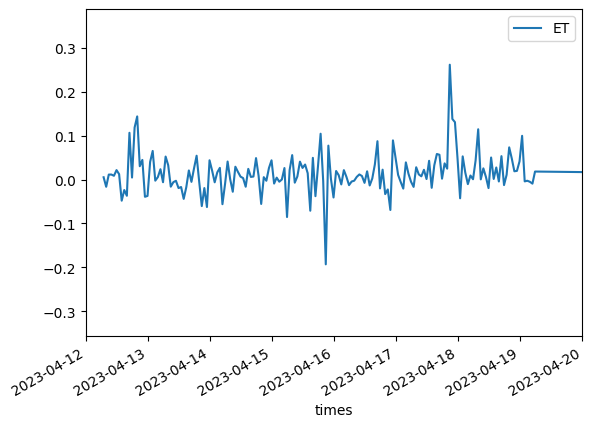

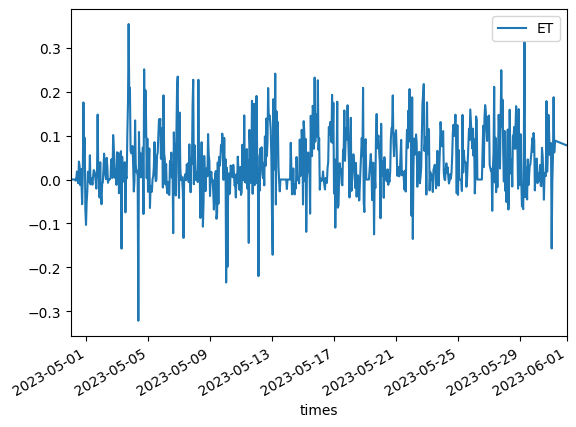

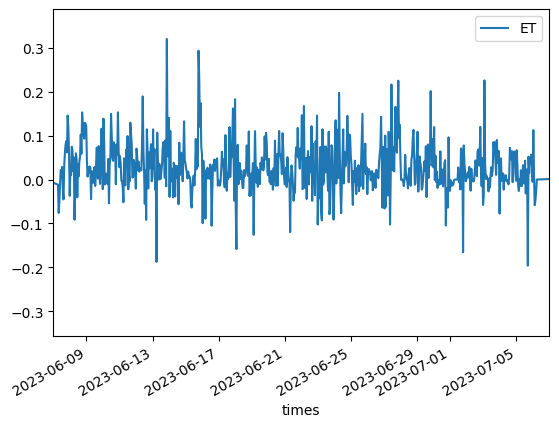

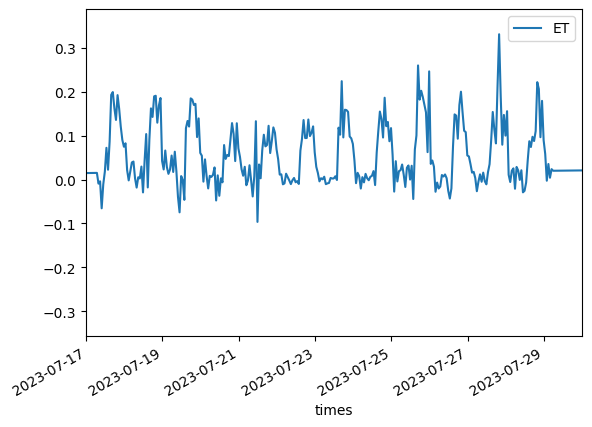

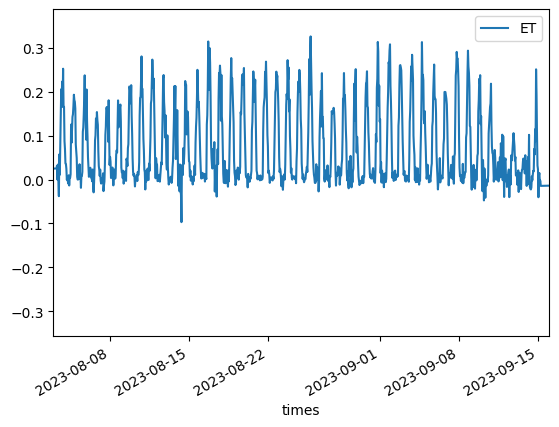

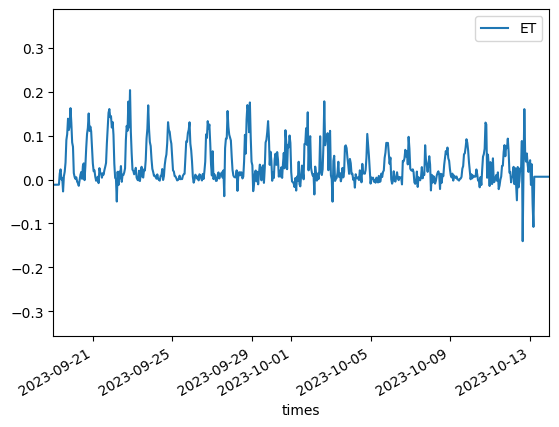

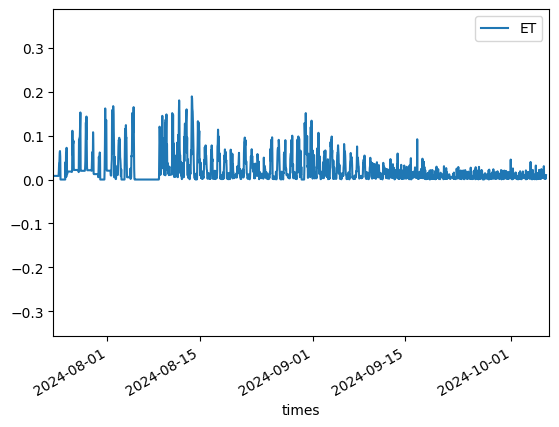

In [116]:
for xlim in xlim_list:
    daily_flux.plot(x='times',y='ET',xlim=xlim)

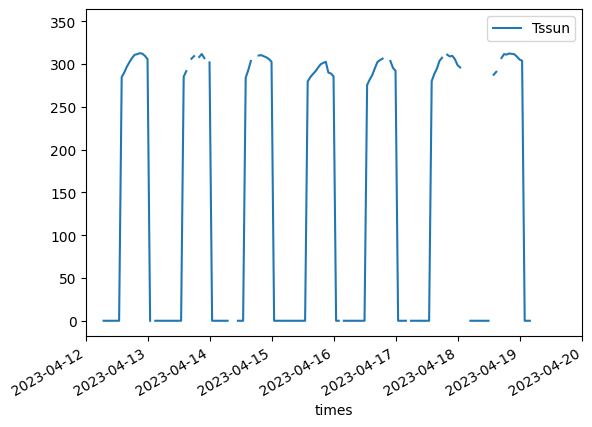

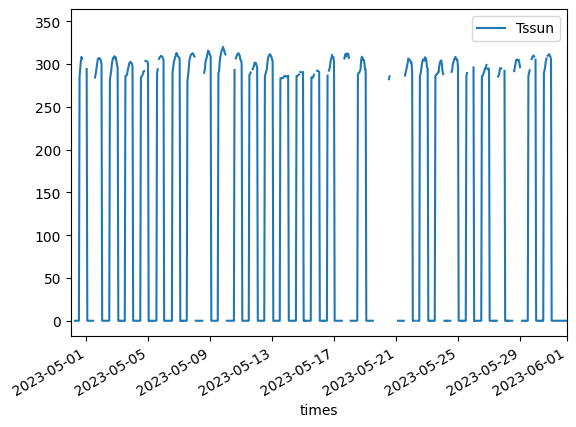

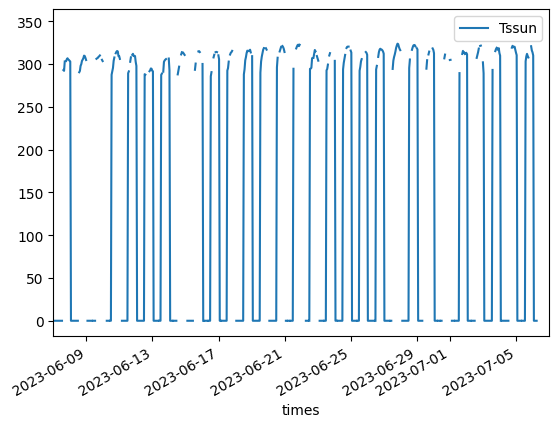

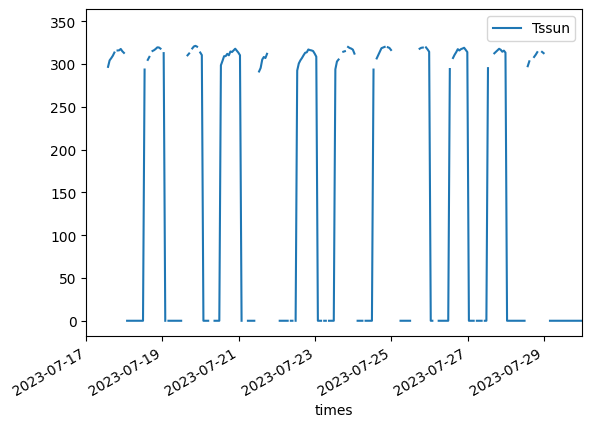

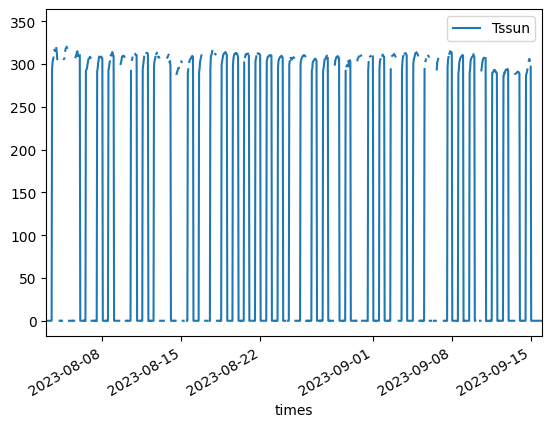

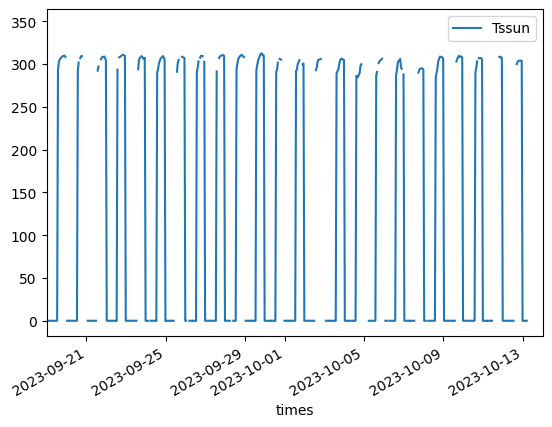

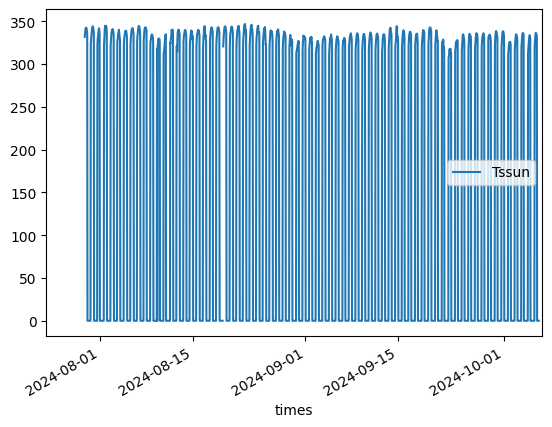

In [117]:
for xlim in xlim_list:
    daily_flux.plot(x='times',y='Tssun',xlim=xlim)

In [118]:
#interpolate nan
for i in inputs:
    if 'T' in i:
        daily_flux.loc[:,i]=daily_flux[i].interpolate(method='linear')

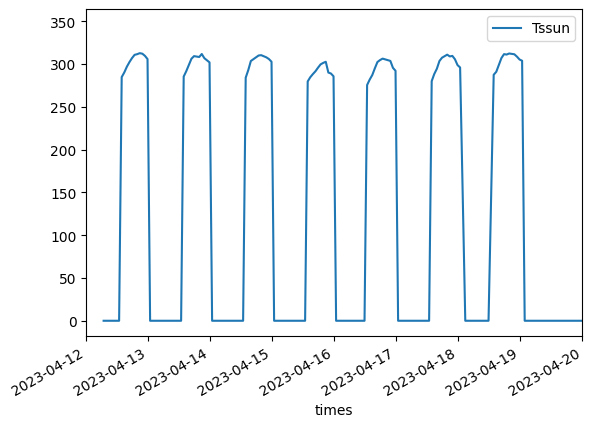

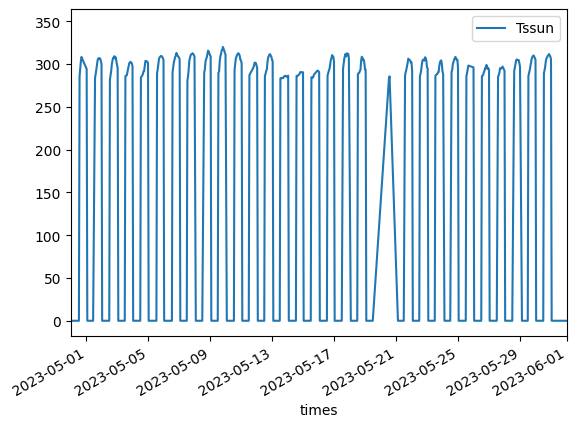

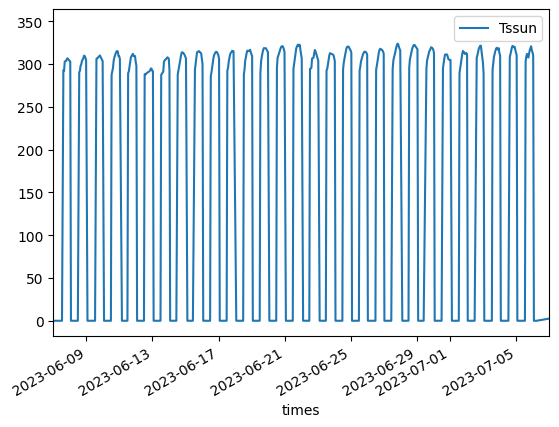

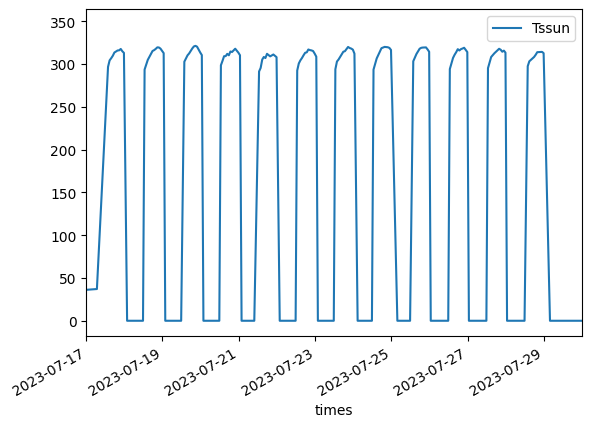

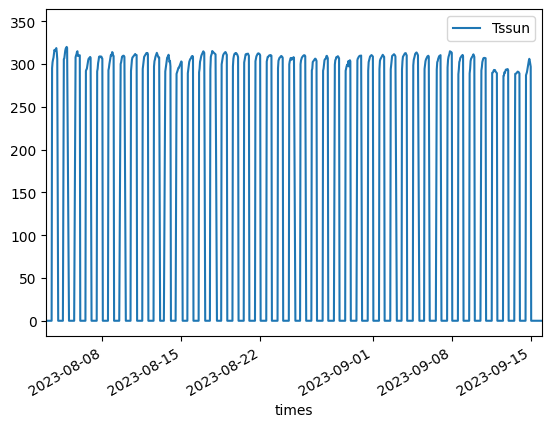

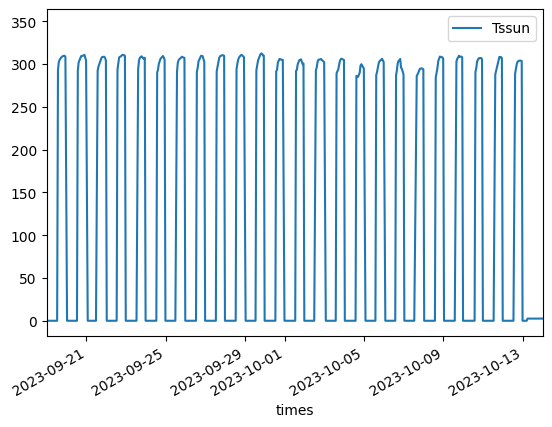

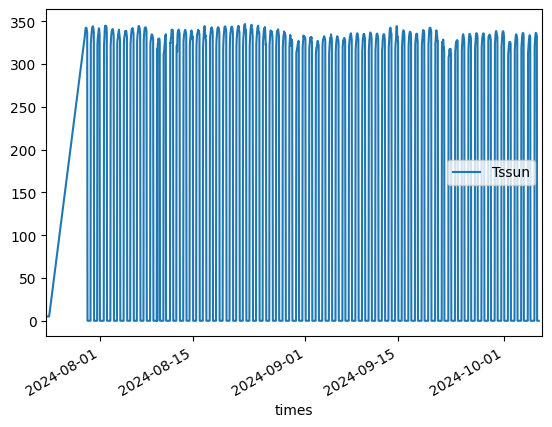

In [119]:
for xlim in xlim_list:
    daily_flux.plot(x='times',y='Tssun',xlim=xlim)

In [120]:
daily_flux.to_csv('/90daydata/nsaru/work/CookIRCamET/Working/cprl_et_batches_processed_'+datestr+'.csv', index=False)

In [122]:
(daily_flux.hvplot.scatter(x='times',y='Tssun')+daily_flux.hvplot.scatter(x='times',y='ET')).cols(1)

/project/nsaru/nsaru-cv/lib/python3.11/site-packages/bokeh/core/property/bases.py:272: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return new == old


:Layout
   .Scatter.I  :Scatter   [times]   (Tssun)
   .Scatter.II :Scatter   [times]   (ET)